### Импорт библиотек

In [1]:
import tarfile
import json 
from typing import List
from functools import partial
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import euclidean, cosine
from sklearn.metrics import pairwise_distances

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from imblearn.over_sampling import ADASYN

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score,  mean_squared_error, adjusted_rand_score
from sklearn.metrics import make_scorer

### Загрузка данных

In [2]:
#Распаковка архива
zipfile = 'hackathon_files_for_participants_ozon.tar.gz'
tar = tarfile.open(zipfile,"r:gz")
tar.extractall()
tar.close()

In [3]:
#Загрузка данных
df_train = pd.read_parquet('hackathon_files_for_participants_ozon/train_data.parquet', engine='pyarrow').reset_index(drop=True)
df_test = pd.read_parquet('hackathon_files_for_participants_ozon/test_data.parquet', engine='pyarrow').reset_index(drop=True)
df_train_pairs = pd.read_parquet('hackathon_files_for_participants_ozon/train_pairs.parquet', engine='pyarrow').reset_index(drop=True)
df_test_pairs = pd.read_parquet('hackathon_files_for_participants_ozon/test_pairs_wo_target.parquet', engine='pyarrow').reset_index(drop=True)

In [4]:
#Категории по уровням
df_train = df_train.join(pd.json_normalize(df_train.categories.apply(json.loads)))
df_test = df_test.join(pd.json_normalize(df_test.categories.apply(json.loads)))

In [5]:
df_train.rename(columns = {'1':'cat1', '2':'cat2', '3':'cat3', '4':'cat4'}, inplace = True )
df_test.rename(columns = {'1':'cat1', '2':'cat2', '3':'cat3', '4':'cat4'}, inplace = True )

In [6]:
df_train.shape

(457063, 12)

In [7]:
cat3_counts = df_train.cat3.value_counts().to_dict()
cat3_counts

{'Смартфоны, планшеты, мобильные телефоны': 59389,
 'Компьютер': 57572,
 'Чехол': 40775,
 'Расходник для печати': 38878,
 'Кабели и переходники': 26669,
 'Наушники и гарнитуры': 16944,
 'Смарт-часы': 14811,
 'Устройство ручного ввода': 14235,
 'Батарейки и аккумуляторы': 12548,
 'Зарядные устройства и док-станции': 12014,
 'Запчасти для ноутбуков': 11791,
 'Запчасти для смартфонов': 10716,
 'Жесткие диски, SSD и сетевые накопители': 10221,
 'Материнская плата': 9895,
 'Видеонаблюдение': 9791,
 'Защитные пленки и стекла': 9225,
 'Оптические приборы': 5874,
 'Карты памяти и флешки': 5741,
 'Телевизоры': 5504,
 'Игровая приставка': 5300,
 'Акустика и колонки': 5287,
 'Электронные модули': 5144,
 'Сетевое оборудование': 5026,
 'Видеокарты и графические ускорители': 4578,
 'Мониторы и запчасти': 4361,
 'Оперативная память': 3877,
 'Сетевые фильтры, разветвители и удлинители': 3658,
 'Принтеры и МФУ': 3643,
 'Аксессуары для фото и видеотехники': 2905,
 'Кронштейн': 2650,
 'Видеорегистратор':

In [8]:
cntr = 0
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 1000:
        cntr += cat3_counts[cat3]
        
cntr

11296

In [9]:
df_train['cat3_grouped'] = df_train.cat3.apply(lambda x: x if cat3_counts[x] > 1000 else 'rest')

### Предобработка данных

In [10]:
merged = df_train_pairs.merge(df_train.add_suffix('1'), on = 'variantid1', how = 'left')
train = merged.merge(df_train.add_suffix('2'), on = 'variantid2', how = 'left')

In [11]:
merged = df_test_pairs.merge(df_test.add_suffix('1'), on = 'variantid1', how = 'left')
test = merged.merge(df_test.add_suffix('2'), on = 'variantid2', how = 'left')

In [12]:
#Косинусное расстояние (картинки)
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles: List[int]):      
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(main_pic_embeddings_1, main_pic_embeddings_2)
    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features




In [13]:
#Косинусное сходство (текст)
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt') # if necessary...
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]
'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))
vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words=['english','russian'])
def cosine_sim(text1, text2):
    try:
        tfidf = vectorizer.fit_transform([text1, text2])
        cos_sim = ((tfidf * tfidf.T).A)[0,1]
    except: 
        cos_sim = 0
    return cos_sim

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tamar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
#Заполним пропуски
train.characteristic_attributes_mapping1.fillna('{}', inplace=True)
train.characteristic_attributes_mapping2.fillna('{}', inplace=True)
test.characteristic_attributes_mapping1.fillna('{}', inplace=True)
test.characteristic_attributes_mapping2.fillna('{}', inplace=True)

In [15]:
#Оставим только совпадающие характеристики
def attr(attributes1, attributes2):
    dict1 = json.loads(attributes1)
    dict2 = json.loads(attributes2)
    common_keys = set(dict1.keys()) & set(dict2.keys())
    new_dict1 = {key: dict1[key] for key in common_keys}
    new_dict2 = {key: dict2[key] for key in common_keys}
    attributes1 = ' '.join('{}: {}; '.format(key,', '.join(str(x) for x in val)) for key, val in new_dict1.items())
    attributes2 = ' '.join('{}: {}; '.format(key,', '.join(str(x) for x in val)) for key, val in new_dict2.items())
    return attributes1, attributes2

In [16]:
train[['attributes1', 'attributes2']] = (
    train[['characteristic_attributes_mapping1', 'characteristic_attributes_mapping2']].apply(
        lambda x: pd.Series(attr(*x)), axis=1))
test[['attributes1', 'attributes2']] = (
    test[['characteristic_attributes_mapping1', 'characteristic_attributes_mapping2']].apply(
        lambda x: pd.Series(attr(*x)), axis=1))

In [17]:
get_pic_features_func = partial(get_pic_features,percentiles=[0, 25, 50])

In [18]:
train[['main_pic_dist_0_perc', 'main_pic_dist_25_perc', 'main_pic_dist_50_perc']] = (
    train[['main_pic_embeddings_resnet_v11', 'main_pic_embeddings_resnet_v12']].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1))
train[['pic_dist_0_perc', 'pic_dist_25_perc', 'pic_dist_50_perc']] = (
    train[['pic_embeddings_resnet_v11', 'pic_embeddings_resnet_v12']].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1))

In [19]:
train['cosine_name_sim'] = (
    train[['name1', 'name2']].apply(
        lambda x: pd.Series(cosine_sim(*x)), axis=1))
train['cosine_attr_sim'] = (
    train[['attributes1', 'attributes2']].apply(
        lambda x: pd.Series(cosine_sim(*x)), axis=1))

In [20]:
test[['main_pic_dist_0_perc', 'main_pic_dist_25_perc', 'main_pic_dist_50_perc']] = (
    test[['main_pic_embeddings_resnet_v11', 'main_pic_embeddings_resnet_v12']].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1))
test[['pic_dist_0_perc', 'pic_dist_25_perc', 'pic_dist_50_perc']] = (
    test[['pic_embeddings_resnet_v11', 'pic_embeddings_resnet_v12']].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1))

In [21]:
test['cosine_name_sim'] = (
    test[['name1', 'name2']].apply(
        lambda x: pd.Series(cosine_sim(*x)), axis=1))
test['cosine_attr_sim'] = (
    test[['attributes1', 'attributes2']].apply(
        lambda x: pd.Series(cosine_sim(*x)), axis=1))

In [22]:
feats = ['main_pic_dist_0_perc', 'main_pic_dist_25_perc', 'main_pic_dist_50_perc', 'pic_dist_0_perc', 'pic_dist_25_perc', 'pic_dist_50_perc', 
         'cosine_name_sim', 'cosine_attr_sim']

In [23]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:

    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])

    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]

    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    # calculate metric for each big category
    for i, category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # calculate category weight anyway
        weights.append(counts[i] / len(categories))
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
        except ValueError:
            pr_aucs.append(0)
            
    return np.average(pr_aucs, weights=weights)

In [24]:
def all_metrics(y_true, y_pred, y_pred_proba, y_test, X_test):
    dict_metric = {}
    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 1) & (y_pred == 0))
    FN = np.sum((y_true == 0) & (y_pred == 1))
    
    pr_auc_macro_metr = pr_auc_macro(
            target_df=pd.DataFrame(y_test), 
            predictions_df=X_test,
            prec_level=0.75,
            cat_column='cat3_grouped1'
            )

    dict_metric['P'] = [P, 'ЕСТЬ совпадение товаров']
    dict_metric['N'] = [N, 'НЕТ совпадения товаров ']
    dict_metric['TP'] = [TP, 'Истинно совпавшие']
    dict_metric['TN'] = [TN, 'Истинно не-совпавшие']
    dict_metric['FP'] = [FP, 'Ложно совпавшие']
    dict_metric['FN'] = [FN, 'Ложно не-совпавшие']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred), 'Доля верно определённых']
    dict_metric['Precision'] = [precision_score(y_true, y_pred), 'Точность определения']
    dict_metric['Recall'] = [recall_score(y_true, y_pred), 'Полнота определения']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Среднее гармоническое Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_proba), 'ROC-AUC']
    dict_metric['AUPRC'] = [average_precision_score(y_true, y_pred_proba), 'AUPRC']
    dict_metric['pr_auc_macro_metr'] = [pr_auc_macro_metr, 'pr_auc_macro_metr']

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Значение', 'Описание метрики'])
    display(temp_df)

In [25]:
X_train, X_test = train_test_split(train[feats + ['target', 'variantid1', 'variantid2', 'cat3_grouped1']], 
    test_size=0.2, random_state=42, stratify=train[['target', 'cat3_grouped1']])

X_train, X_val = train_test_split(X_train[feats + ['target', 'variantid1', 'variantid2', 'cat3_grouped1']], 
    test_size=0.2, random_state=42, stratify=X_train[['target', 'cat3_grouped1']])

y_test = X_test[['target', 'variantid1', 'variantid2']]
X_test = X_test.drop(['target'], axis=1)

y_train = X_train['target']
y_val = X_val['target']

X_train = X_train.drop(['target'], axis=1)
X_val = X_val.drop(['target'], axis=1)


train_pool = Pool(data=X_train[feats], label=y_train)
eval_pool = Pool(data=X_val[feats], label=y_val)

In [26]:
estimators = [('ets', ExtraTreesClassifier()),
              ('et', ExtraTreeClassifier()),
              ('dt', DecisionTreeClassifier()),
              ('rf', RandomForestClassifier()),
              ('knn', KNeighborsClassifier()),
              ('mlp', MLPClassifier()),
              ('bc', BaggingClassifier()),
              ('gbc', GradientBoostingClassifier()),
              ('cat', CatBoostClassifier()),
             ('ada', AdaBoostClassifier())]
model = VotingClassifier(estimators=estimators, voting='soft', weights=[1,1,1,1,1,1,1,2,2,2], flatten_transform=True)

model.fit(X_train[feats], y_train.values)

y_pred_proba = model.predict_proba(X_test[feats])[:, 1]
y_pred = model.predict(X_test[feats])
X_test['scores'] = model.predict_proba(X_test[feats])[:, 1]
all_metrics(y_test.target, y_pred, y_pred_proba, y_test, X_test)

Learning rate set to 0.098153
0:	learn: 0.6734265	total: 207ms	remaining: 3m 27s
1:	learn: 0.6580695	total: 260ms	remaining: 2m 9s
2:	learn: 0.6455439	total: 311ms	remaining: 1m 43s
3:	learn: 0.6342814	total: 365ms	remaining: 1m 30s
4:	learn: 0.6247819	total: 410ms	remaining: 1m 21s
5:	learn: 0.6172677	total: 452ms	remaining: 1m 14s
6:	learn: 0.6108691	total: 493ms	remaining: 1m 9s
7:	learn: 0.6058323	total: 533ms	remaining: 1m 6s
8:	learn: 0.6016758	total: 562ms	remaining: 1m 1s
9:	learn: 0.5976000	total: 586ms	remaining: 58s
10:	learn: 0.5946795	total: 607ms	remaining: 54.6s
11:	learn: 0.5919746	total: 628ms	remaining: 51.7s
12:	learn: 0.5896410	total: 652ms	remaining: 49.5s
13:	learn: 0.5870159	total: 671ms	remaining: 47.3s
14:	learn: 0.5847462	total: 692ms	remaining: 45.4s
15:	learn: 0.5832426	total: 713ms	remaining: 43.9s
16:	learn: 0.5813643	total: 733ms	remaining: 42.4s
17:	learn: 0.5798707	total: 751ms	remaining: 41s
18:	learn: 0.5788032	total: 771ms	remaining: 39.8s
19:	learn:

165:	learn: 0.5303110	total: 3.91s	remaining: 19.6s
166:	learn: 0.5301137	total: 3.93s	remaining: 19.6s
167:	learn: 0.5299416	total: 3.95s	remaining: 19.6s
168:	learn: 0.5298486	total: 3.97s	remaining: 19.5s
169:	learn: 0.5296572	total: 3.99s	remaining: 19.5s
170:	learn: 0.5295912	total: 4.01s	remaining: 19.4s
171:	learn: 0.5294691	total: 4.03s	remaining: 19.4s
172:	learn: 0.5293273	total: 4.05s	remaining: 19.4s
173:	learn: 0.5292456	total: 4.07s	remaining: 19.3s
174:	learn: 0.5290990	total: 4.09s	remaining: 19.3s
175:	learn: 0.5289651	total: 4.11s	remaining: 19.3s
176:	learn: 0.5288127	total: 4.14s	remaining: 19.2s
177:	learn: 0.5286390	total: 4.16s	remaining: 19.2s
178:	learn: 0.5285180	total: 4.18s	remaining: 19.2s
179:	learn: 0.5284445	total: 4.2s	remaining: 19.1s
180:	learn: 0.5283816	total: 4.22s	remaining: 19.1s
181:	learn: 0.5281323	total: 4.24s	remaining: 19.1s
182:	learn: 0.5280073	total: 4.26s	remaining: 19s
183:	learn: 0.5279491	total: 4.28s	remaining: 19s
184:	learn: 0.527

332:	learn: 0.5133537	total: 7.33s	remaining: 14.7s
333:	learn: 0.5132852	total: 7.35s	remaining: 14.7s
334:	learn: 0.5132432	total: 7.37s	remaining: 14.6s
335:	learn: 0.5131945	total: 7.39s	remaining: 14.6s
336:	learn: 0.5131121	total: 7.41s	remaining: 14.6s
337:	learn: 0.5130388	total: 7.43s	remaining: 14.6s
338:	learn: 0.5129632	total: 7.45s	remaining: 14.5s
339:	learn: 0.5129120	total: 7.47s	remaining: 14.5s
340:	learn: 0.5128624	total: 7.49s	remaining: 14.5s
341:	learn: 0.5127440	total: 7.51s	remaining: 14.5s
342:	learn: 0.5126816	total: 7.53s	remaining: 14.4s
343:	learn: 0.5126082	total: 7.55s	remaining: 14.4s
344:	learn: 0.5125269	total: 7.57s	remaining: 14.4s
345:	learn: 0.5124773	total: 7.59s	remaining: 14.4s
346:	learn: 0.5124056	total: 7.61s	remaining: 14.3s
347:	learn: 0.5123536	total: 7.63s	remaining: 14.3s
348:	learn: 0.5123103	total: 7.65s	remaining: 14.3s
349:	learn: 0.5122669	total: 7.67s	remaining: 14.3s
350:	learn: 0.5122034	total: 7.69s	remaining: 14.2s
351:	learn: 

499:	learn: 0.5040784	total: 10.8s	remaining: 10.8s
500:	learn: 0.5040443	total: 10.8s	remaining: 10.8s
501:	learn: 0.5039502	total: 10.8s	remaining: 10.7s
502:	learn: 0.5039050	total: 10.8s	remaining: 10.7s
503:	learn: 0.5038411	total: 10.9s	remaining: 10.7s
504:	learn: 0.5037939	total: 10.9s	remaining: 10.7s
505:	learn: 0.5037517	total: 10.9s	remaining: 10.6s
506:	learn: 0.5037137	total: 10.9s	remaining: 10.6s
507:	learn: 0.5036819	total: 10.9s	remaining: 10.6s
508:	learn: 0.5036294	total: 11s	remaining: 10.6s
509:	learn: 0.5035917	total: 11s	remaining: 10.6s
510:	learn: 0.5035485	total: 11s	remaining: 10.5s
511:	learn: 0.5035008	total: 11s	remaining: 10.5s
512:	learn: 0.5034643	total: 11s	remaining: 10.5s
513:	learn: 0.5034325	total: 11.1s	remaining: 10.5s
514:	learn: 0.5033889	total: 11.1s	remaining: 10.4s
515:	learn: 0.5033370	total: 11.1s	remaining: 10.4s
516:	learn: 0.5032967	total: 11.1s	remaining: 10.4s
517:	learn: 0.5032481	total: 11.1s	remaining: 10.4s
518:	learn: 0.5031978	

665:	learn: 0.4968378	total: 14.2s	remaining: 7.13s
666:	learn: 0.4967797	total: 14.2s	remaining: 7.11s
667:	learn: 0.4967501	total: 14.3s	remaining: 7.09s
668:	learn: 0.4967189	total: 14.3s	remaining: 7.07s
669:	learn: 0.4966845	total: 14.3s	remaining: 7.05s
670:	learn: 0.4966598	total: 14.3s	remaining: 7.03s
671:	learn: 0.4966206	total: 14.3s	remaining: 7s
672:	learn: 0.4965684	total: 14.4s	remaining: 6.98s
673:	learn: 0.4965314	total: 14.4s	remaining: 6.96s
674:	learn: 0.4964945	total: 14.4s	remaining: 6.94s
675:	learn: 0.4964504	total: 14.4s	remaining: 6.92s
676:	learn: 0.4964075	total: 14.4s	remaining: 6.89s
677:	learn: 0.4963678	total: 14.5s	remaining: 6.87s
678:	learn: 0.4963183	total: 14.5s	remaining: 6.85s
679:	learn: 0.4962736	total: 14.5s	remaining: 6.83s
680:	learn: 0.4962468	total: 14.5s	remaining: 6.81s
681:	learn: 0.4961904	total: 14.6s	remaining: 6.79s
682:	learn: 0.4961612	total: 14.6s	remaining: 6.76s
683:	learn: 0.4961314	total: 14.6s	remaining: 6.74s
684:	learn: 0.4

826:	learn: 0.4910327	total: 17.7s	remaining: 3.69s
827:	learn: 0.4910017	total: 17.7s	remaining: 3.67s
828:	learn: 0.4909728	total: 17.7s	remaining: 3.65s
829:	learn: 0.4909477	total: 17.7s	remaining: 3.63s
830:	learn: 0.4909037	total: 17.8s	remaining: 3.61s
831:	learn: 0.4908517	total: 17.8s	remaining: 3.59s
832:	learn: 0.4908073	total: 17.8s	remaining: 3.57s
833:	learn: 0.4907440	total: 17.8s	remaining: 3.55s
834:	learn: 0.4907081	total: 17.8s	remaining: 3.52s
835:	learn: 0.4906788	total: 17.9s	remaining: 3.5s
836:	learn: 0.4906584	total: 17.9s	remaining: 3.48s
837:	learn: 0.4906014	total: 17.9s	remaining: 3.46s
838:	learn: 0.4905633	total: 17.9s	remaining: 3.44s
839:	learn: 0.4905226	total: 17.9s	remaining: 3.42s
840:	learn: 0.4904836	total: 18s	remaining: 3.4s
841:	learn: 0.4904615	total: 18s	remaining: 3.38s
842:	learn: 0.4904268	total: 18s	remaining: 3.35s
843:	learn: 0.4903869	total: 18s	remaining: 3.33s
844:	learn: 0.4903663	total: 18.1s	remaining: 3.31s
845:	learn: 0.4903373	

986:	learn: 0.4859512	total: 20.9s	remaining: 276ms
987:	learn: 0.4859244	total: 20.9s	remaining: 254ms
988:	learn: 0.4859017	total: 21s	remaining: 233ms
989:	learn: 0.4858576	total: 21s	remaining: 212ms
990:	learn: 0.4858354	total: 21s	remaining: 191ms
991:	learn: 0.4858048	total: 21s	remaining: 170ms
992:	learn: 0.4857666	total: 21s	remaining: 148ms
993:	learn: 0.4857326	total: 21.1s	remaining: 127ms
994:	learn: 0.4857114	total: 21.1s	remaining: 106ms
995:	learn: 0.4856744	total: 21.1s	remaining: 84.8ms
996:	learn: 0.4856483	total: 21.1s	remaining: 63.6ms
997:	learn: 0.4856263	total: 21.1s	remaining: 42.4ms
998:	learn: 0.4855967	total: 21.2s	remaining: 21.2ms
999:	learn: 0.4855705	total: 21.2s	remaining: 0us


,Значение,Описание метрики
P,27003.000000,ЕСТЬ совпадение товаров
N,34305.000000,НЕТ совпадения товаров
TP,18541.000000,Истинно совпавшие
TN,27150.000000,Истинно не-совпавшие
FP,8462.000000,Ложно совпавшие
FN,7155.000000,Ложно не-совпавшие
Accuracy,0.745270,Доля верно определённых
Precision,0.721552,Точность определения
Recall,0.686627,Полнота определения
F1-score,0.703657,Среднее гармоническое Precision и Recall


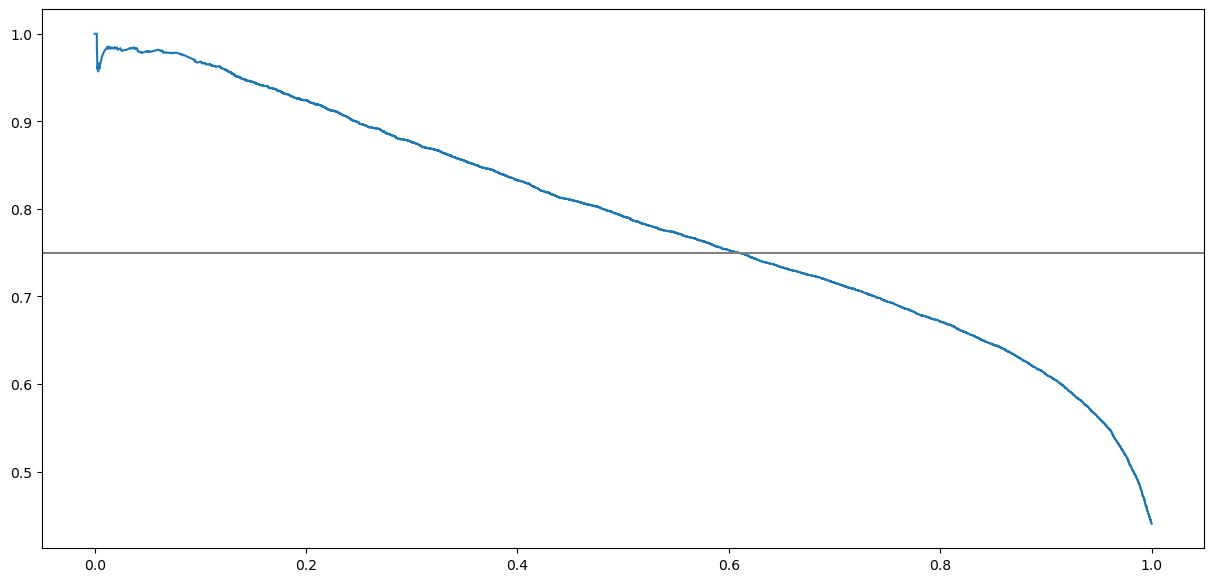

In [27]:
precision, recall, thrs = precision_recall_curve(y_test['target'], X_test['scores'])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

In [28]:
import pickle
# save
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

In [30]:
# load
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

### Submission

In [31]:
test.shape

(18084, 34)

In [32]:
test_cat3_counts = test.cat31.value_counts().to_dict()

cntr = 0
for cat3 in test_cat3_counts:
    if test_cat3_counts[cat3] < 50:
        cntr += test_cat3_counts[cat3]
        
cntr

537

In [33]:
test['cat3_grouped'] = test.cat31.apply(lambda x: x if test_cat3_counts[x] > 50 else 'rest')

In [34]:
submission = test.copy()

In [35]:
submission['target'] = model.predict_proba(test[feats])[:, 1]

In [36]:
submission = submission[['variantid1', 'variantid2', 'cat3_grouped', 'target']]

In [37]:
submission.drop_duplicates().to_csv('submission_sc51.csv', index=False)